This notebook contains the code to compare the transition probabilities of a Lorenz 63 system coupled to a quadratic  potential well with those of a homogenized system and the Edgeworth approximation.

In [19]:
using PyCall, PyPlot
@pyimport matplotlib.backends.backend_pdf as backend_pdf
using JLD
@everywhere using HDF5
@everywhere using ODE
using StatsBase
using Distributions
@everywhere using Bridge

H₁(x) = x 
H₂(x) = x.^2 - 1 
H₃(x) = x.^3 - 3*x
H₄(x) = x.^4 - 6*x.^2 + 3
H₅(x) = x.^5 - 10*x.^3 + 15*x
H₆(x) = x.^6 - 15*x.^4 + 45*x.^2 - 15 
fₑ₂ₘ(x,c⁽¹⁾,σ,c₁⁽²⁾,c⁽³⁾,c⁽⁴⁾,ε) = 
pdf.(Normal(0,σ),x).*(1 + √ε*((c⁽¹⁾/σ)*H₁(x/σ) + (c⁽³⁾/(6*σ^3))*H₃(x/σ))
    + ε*(((c₁⁽²⁾+c⁽¹⁾^2)/(2*σ^2))*H₂(x/σ) + ((c⁽⁴⁾+4*c⁽¹⁾*c⁽³⁾)/(24*σ^4))*H₄(x/σ) + (c⁽³⁾^2/(72*σ^6))*H₆(x/σ)))

fₑ₂ₘ (generic function with 1 method)

In [4]:
rc("text",usetex=true)
#rc("font", size=20, family="normal", serif = "STIX")
rc("text.latex", preamble="\\usepackage{amssymb}")
rc("font", size=20)
rc("lines", linewidth=2)
#rc("pdf", fonttype=42)
#rc("svg", fonttype="svgfont")
rc("figure", figsize=(7,5))

In [5]:
# Define a diffusion process
@everywhere struct OrnsteinUhlenbeck  <: ContinuousTimeProcess{Float64}
    β::Float64 # drift parameter (also known as inverse relaxation time)
    σ::Float64 # diffusion parameter
    function OrnsteinUhlenbeck(β::Float64, σ::Float64)
        isnan(β) || β > 0. || error("Parameter λ must be positive.")
        isnan(σ) || σ > 0. || error("Parameter σ must be positive.")
        new(β, σ)
    end
end

# define drift and diffusion coefficient of OrnsteinUhlenbeck
@everywhere Bridge.b(t, x, P::OrnsteinUhlenbeck) = -P.β*x
@everywhere Bridge.σ(t, x, P::OrnsteinUhlenbeck) = P.σ
@everywhere Bridge.a(t, x, P::OrnsteinUhlenbeck) = P.σ^2


In [6]:
@everywhere α = .1
@everywhere σ = 1.
V(x) = α*x.^2
@everywhere f₁(x) = -α*x
f₁ₓ(x) = -α
#f₁(x) = 0

f₁ₓ (generic function with 1 method)

In [7]:
@everywhere σₕ = σ
β = 2/σₕ^2

2.0

### deterministic system

In [8]:
@everywhere h5open("edgeworth-coeff-24-10-2017-10.29.12-submitted-cmp.h5", "r") do file
    global f₀ₛ, μ₁, μ₂₀, μ₂₁, μ₃₀, μ₄₀
    f₀ₛ, μ₁, μ₂₀, μ₂₁, μ₃₀, μ₄₀ = read(file, "f₀ₛ", "μ₁", "μ₂₀", "μ₂₁",  "μ₃₀", "μ₄₀")
end

In [9]:
#f₀ₛ =   "sin(y[1]*y[2]/4)*cos(y[2]/2)*(exp(y[1]/40))"
#f₀(y) =  sin(y[1]*y[2]/4)*cos(y[2]/2)*(exp(y[1]/40))
@everywhere eval(parse("f₀(y)="*f₀ₛ))

@everywhere σₘ = σₕ/sqrt(μ₂₀)

In [17]:
jₚₘ = 1000
Tₚ = tₘ[iₘ][jₚₘ]

#loadstr = nowstr
loadstr = "26-10-2017-10.01.11"
R = 10
#R = 1

#x₀ = load("../data/lorenz63-quadratic-pot-paths-"*loadstr*"run1.jld", "x₀")
x₀ = 1.
#iₑ = load("../data/lorenz63-quadratic-pot-paths-"*loadstr*"run1.jld", "iₑ")
#f₀ₛ = load("../data/lorenz63-quadratic-pot-paths-"*loadstr*"run1.jld","f₀ₛ")
σₘ = load("../../data/lorenz63-quadratic-pot-paths-"*loadstr*"run1.jld","σₘ")
ε = load("../../data/lorenz63-quadratic-pot-paths-"*loadstr*"run1.jld","ε")
α = load("../../data/lorenz63-quadratic-pot-paths-"*loadstr*"run1.jld","α")
σ = σₘ*sqrt(μ₂₀)

f₁(x) = -α*x
f₁ₓ(x) = -α
c¹ₕ = f₁(x₀)
c²ₕ = σ^2*f₁ₓ(x₀)
c³ₕ = 0;
c⁴ₕ = 0;

xₚ = linspace(x₀ - 5*σ*√Tₚ,x₀ + 5*σ*√Tₚ,75)
χ = zeros(R,length(xₚ)-1)
for r=1:R
    yₘ = load("../../data/lorenz63-quadratic-pot-paths-"*loadstr*"run"*string(r)*".jld", "xₘ")
    χ[r,:] = fit(Histogram,yₘ[:,jₚₘ],xₚ,closed=:left).weights/size(yₘ)[1]
end

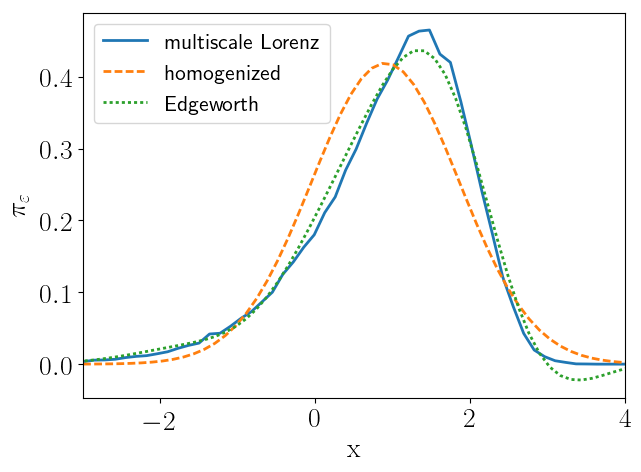

(-3, 4)

In [20]:
## plot(x,ρ)
#Tₚ = .2
#iₚₕ = findfirst(x->x==Tₚ,tₕ)
#iₚₘ = findfirst(x->x==Tₚ,tₘ)

#Tₚ = 1.
#iₚₕ = 1001

θ = Tₚ/ε
#plt[:hist](vec(xₕ[:,end]), bins=50,normed=true);
#plt[:hist](vec(xₘ[:,end]), bins=50,normed=true);
plot((xₚ[1:end-1] + xₚ[2:end])/2,vec(mean(χ,1))./diff(xₚ),label="multiscale Lorenz")
plot(xₚ,pdf.(Normal(x₀*exp(-α*Tₚ),sqrt(σ^2/(2*α))*√(1-exp(-2*α*Tₚ))),xₚ), ls="--", label="homogenized")
#plot(xₚ,fₑ₂ₘ((xₚ-x₀)/(√Tₚ),c¹ₕ,σ,c²ₕ,c³ₕ,c⁴ₕ,Tₚ)./√Tₚ, label="Edgeworth", ls=":")
plot(xₚ,fₑ₂ₘ((xₚ-x₀)/(√Tₚ),c¹ₕ,σ,c²ₕ + μ₂₁*(σₘ/θ)^2,c³ₕ + μ₃₀*(σₘ^3/θ),c⁴ₕ + μ₄₀*(σₘ^4/θ^2),Tₚ)./√Tₚ, label="Edgeworth", ls=":")

#plot(xₑ,fₑ₂((xₑ)/√tₑ[iₑ[jₚ]],0,sqrt(μ₂₀),μ₂₁,μ₃₀,μ₄₀,1/tₑ[iₑ[jₚ]])./√tₑ[iₑ[jₚ]], label="Edgeworth", ls=":")
legend(fontsize=16)
xlabel(L"\mathrm{x}")
ylabel(L"\pi_\varepsilon")
tstr = @sprintf("%0.2f", Tₚ)
xstr = @sprintf("%0.2f", x₀)
xlim(-3,4)
#savefig("../../plots/edgeworth_expansion_of_quadratic_multiscale_lorenz_eps="*string(ε)*"_t="*tstr*"_x0="*xstr*"_f0="*replace(replace(f₀ₛ,"*",""),"/","%")*"_alpha="*string(α)*"_sigma="*string(σ)*".pdf", bbox_inches="tight")